In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import random
from numpy.linalg import pinv
from numpy.linalg import inv
random.seed(0)

**Set hyper-parameters for the dataset:**

In [2]:
sd = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col="Date")
predictionStep = 5

In [3]:
sd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2015-02-01 to 2020-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1447 non-null   float64
 1   High       1447 non-null   float64
 2   Low        1447 non-null   float64
 3   Close      1447 non-null   float64
 4   Adj_Close  1447 non-null   float64
 5   Volume     1447 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 79.1 KB


In [4]:
sd.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

In [5]:
# standardize data by subtracting mean and dividing by std
meanSeq = np.mean(sd['Adj_Close'])
stdSeq = np.std(sd['Adj_Close'])
sd['Adj_Close'] = (sd['Adj_Close'] - meanSeq)/stdSeq
normalized=True

In [6]:
sd.head()

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2015-02-01,27.847500,27.860001,26.837500,27.332500,-0.891262,212818400
2015-05-01,27.072500,27.162500,26.352501,26.562500,-0.924861,257142000
2015-06-01,26.635000,26.857500,26.157499,26.565001,-0.924751,263188400
2015-07-01,26.799999,27.049999,26.674999,26.937500,-0.908498,160423600
2015-08-01,27.307501,28.037500,27.174999,27.972500,-0.863336,237458000


In [7]:
selected_columns = sd.Adj_Close
numCols = len(selected_columns)
numLags=10

def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1):
  print("generate time embedded matrix")
  inDim = numLags
  X = np.zeros(shape=(len(sequence), numCols, inDim)) #  (10886 x 6 x 3)
  T = np.zeros(shape=(len(sequence), 1))
  for i in range(numLags-1, len(sequence)-predictionStep):
    X[i, :] = np.array(sequence["Adj_Close"][(i-numLags+1):(i+1)])
    T[i, :] = sequence['Adj_Close'][i+predictionStep]
  X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
  print('input shape: ',X.shape) # (10886 x 18)
  print('target shape: ',T.shape) # (10886 x 1)
  return (X, T)

(X, T) = getTimeEmbeddedMatrix(sd, numLags=numLags, predictionStep = predictionStep)

generate time embedded matrix
input shape:  (1447, 14470)
target shape:  (1447, 1)


In [8]:
print(X.shape, T.shape)

(1447, 14470) (1447, 1)


In [9]:
T[5]

array([0.])

In [10]:
def linear_recurrent(features, inputW,hiddenW,hiddenA, bias):
  V = np.dot(features, np.transpose(inputW)) + np.dot(hiddenA,hiddenW) + bias
  return V

def linear(features,weights,bias):
   return np.dot(features, np.transpose(weights)) + bias

def sigmoidActFunc(features):
  return 1.0 / (1.0 + np.exp(-features))

def reluActFunc(features):
  return np.maximum(0,features)

def layerNormalization(H, scaleFactor=1, biasFactor=0):

  H_normalized = (H-H.mean())/(np.sqrt(H.var() + 0.000001))
  H_normalized = scaleFactor*H_normalized+biasFactor

  return H_normalized

inputW = np.random.random((20,100))
print('input_weights:',inputW.shape)

hiddenW = np.random.random((20,20))
print('hidden_weights:',hiddenW.shape)

bias = np.random.random((1,20)) * 2 -1
print('bias:', bias.shape)

features = np.random.random((1,100))
print('input features:', features.shape)

hiddenA = np.random.random((1,20))

hidden = linear_recurrent(features,inputW,hiddenW,hiddenA,bias)
print('hidden:',hidden.shape)

hidden = layerNormalization(hidden)
print('hidden:',hidden.shape)

input_weights: (20, 100)
hidden_weights: (20, 20)
bias: (1, 20)
input features: (1, 100)
hidden: (1, 20)
hidden: (1, 20)


In [11]:
nDimInput = 100
nDimOutput = 1
numNeurons = 25
lamb=0.0001
LN=True
InWeightFF=1.0
OutWeightFF=0.92
HiddenWeightFF=1.0
AE=True

In [12]:
class OSELM(object):
  def __init__(self, inputs, outputs, numHiddenNeurons, forgettingFactor=0.999):
    self.name = 'OSELM'
    self.inputs = inputs
    self.outputs = outputs
    self.numHiddenNeurons = numHiddenNeurons

    # input to hidden weights
    self.inputWeights = None
    # bias of hidden units
    self.bias = None
    # hidden to output layer connection
    self.beta = None
    # auxiliary matrix used for sequential learning
    self.M = None

    self.forgettingFactor = forgettingFactor

  def calculateHiddenLayerActivation(self, features):
    """
    Calculate activation level of the hidden layer
    :param features feature matrix with dimension (numSamples, numInputs)
    :return: activation level (numSamples, numHiddenNeurons)
    """
    V = linear(features, self.inputWeights,self.bias)
    #H = sigmoidActFunc(V)
    H = reluActFunc(V)
    return H


  def initializePhase(self, lamb=0.0001):
    """
    Step 1: Initialization phase
    """
    # randomly initialize the input->hidden connections
    self.inputWeights = np.random.random((self.numHiddenNeurons, self.inputs))
    self.inputWeights = self.inputWeights * 2 - 1
    self.bias = np.random.random((1, self.numHiddenNeurons)) * 2 - 1
    # auxiliary matrix used for sequential learning
    self.M = inv(lamb*np.eye(self.numHiddenNeurons))
    # hidden to output layer connection
    self.beta = np.zeros([self.numHiddenNeurons,self.outputs])



  def train(self, features, targets):
    """
    Step 2: Sequential learning phase
    :param features feature matrix with dimension (numSamples, numInputs)
    :param targets target matrix with dimension (numSamples, numOutputs)
    """
    (numSamples, numOutputs) = targets.shape
    assert features.shape[0] == targets.shape[0]

    H = self.calculateHiddenLayerActivation(features)
    Ht = np.transpose(H)


    self.M = (1/self.forgettingFactor) * self.M - np.dot((1/self.forgettingFactor) * self.M,
                                     np.dot(Ht, np.dot(
                                       pinv(np.eye(numSamples) + np.dot(H, np.dot((1/self.forgettingFactor) * self.M, Ht))),
                                       np.dot(H, (1/self.forgettingFactor) * self.M))))
    self.beta = self.beta + np.dot(self.M, np.dot(Ht, targets - np.dot(H, self.beta)))

  def predict(self, features):
    """
    Make prediction with feature matrix
    :param features: feature matrix with dimension (numSamples, numInputs)
    :return: predictions with dimension (numSamples, numOutputs)
    """
    H = self.calculateHiddenLayerActivation(features)
    prediction = np.dot(H, self.beta)
    return prediction

In [13]:
selected_columns = sd['Adj_Close']
numCols = len(selected_columns)

net = OSELM(numLags*numCols,outputs=nDimOutput, numHiddenNeurons=25,forgettingFactor=0.9997)
net.initializePhase(lamb=0.0001)

In [14]:
predictions= []
target= []

for i in range(numLags, len(sd)-predictionStep-1):
    net.train(X[[i], :], T[[i], :])
    Y = net.predict(X[[i+1], :])

    predictions.append(Y[0][0])
    target.append(T[i][0])
    txt = "{:5}th timeStep -  target: {:8.4f}   |    prediction: {:8.4f} "
    print (txt.format(i, target[-1], predictions[-1]))

   10th timeStep -  target:  -0.8501   |    prediction:  -0.8433 
   11th timeStep -  target:  -0.8933   |    prediction:  -0.8994 
   12th timeStep -  target:  -0.8260   |    prediction:  -0.8109 
   13th timeStep -  target:  -0.7869   |    prediction:  -0.7869 
   14th timeStep -  target:  -0.8058   |    prediction:  -0.7948 
   15th timeStep -  target:  -0.7898   |    prediction:  -0.7571 
   16th timeStep -  target:  -0.7896   |    prediction:  -0.8741 
   17th timeStep -  target:  -0.7797   |    prediction:  -0.8220 
   18th timeStep -  target:  -0.7704   |    prediction:  -0.6465 
   19th timeStep -  target:  -0.7814   |    prediction:  -0.6060 
   20th timeStep -  target:  -0.7728   |    prediction:  -1.0793 
   21th timeStep -  target:  -0.7476   |    prediction:  -0.9055 
   22th timeStep -  target:  -0.7163   |    prediction:  -0.6714 
   23th timeStep -  target:  -0.6990   |    prediction:  -0.7855 
   24th timeStep -  target:  -0.6922   |    prediction:  -0.7491 
   25th ti

  225th timeStep -  target:  -0.7821   |    prediction:  -0.7556 
  226th timeStep -  target:  -0.7938   |    prediction:  -0.7632 
  227th timeStep -  target:  -0.8058   |    prediction:  -0.7619 
  228th timeStep -  target:  -0.7633   |    prediction:  -0.7651 
  229th timeStep -  target:  -0.7716   |    prediction:  -0.7689 
  230th timeStep -  target:  -0.7722   |    prediction:  -0.7802 
  231th timeStep -  target:  -0.8012   |    prediction:  -0.7908 
  232th timeStep -  target:  -0.7951   |    prediction:  -0.7637 
  233th timeStep -  target:  -0.8282   |    prediction:  -0.7684 
  234th timeStep -  target:  -0.8360   |    prediction:  -0.7672 
  235th timeStep -  target:  -0.8581   |    prediction:  -0.7911 
  236th timeStep -  target:  -0.8486   |    prediction:  -0.7794 
  237th timeStep -  target:  -0.8748   |    prediction:  -0.8058 
  238th timeStep -  target:  -0.9076   |    prediction:  -0.8130 
  239th timeStep -  target:  -0.8931   |    prediction:  -0.8394 
  240th ti

  445th timeStep -  target:  -0.7566   |    prediction:  -0.7793 
  446th timeStep -  target:  -0.7575   |    prediction:  -0.7777 
  447th timeStep -  target:  -0.7584   |    prediction:  -0.7609 
  448th timeStep -  target:  -0.7624   |    prediction:  -0.7648 
  449th timeStep -  target:  -0.7631   |    prediction:  -0.7534 
  450th timeStep -  target:  -0.7683   |    prediction:  -0.7562 
  451th timeStep -  target:  -0.7564   |    prediction:  -0.7556 
  452th timeStep -  target:  -0.7496   |    prediction:  -0.7616 
  453th timeStep -  target:  -0.7797   |    prediction:  -0.7621 
  454th timeStep -  target:  -0.7922   |    prediction:  -0.7712 
  455th timeStep -  target:  -0.8008   |    prediction:  -0.7615 
  456th timeStep -  target:  -0.8028   |    prediction:  -0.7582 
  457th timeStep -  target:  -0.8259   |    prediction:  -0.7833 
  458th timeStep -  target:  -0.8248   |    prediction:  -0.7940 
  459th timeStep -  target:  -0.8383   |    prediction:  -0.8031 
  460th ti

  585th timeStep -  target:  -0.3410   |    prediction:  -0.4023 
  586th timeStep -  target:  -0.3299   |    prediction:  -0.4056 
  587th timeStep -  target:  -0.3382   |    prediction:  -0.4097 
  588th timeStep -  target:  -0.3231   |    prediction:  -0.3795 
  589th timeStep -  target:  -0.2985   |    prediction:  -0.3352 
  590th timeStep -  target:  -0.3031   |    prediction:  -0.3211 
  591th timeStep -  target:  -0.3057   |    prediction:  -0.3271 
  592th timeStep -  target:  -0.3654   |    prediction:  -0.3091 
  593th timeStep -  target:  -0.3392   |    prediction:  -0.2840 
  594th timeStep -  target:  -0.3333   |    prediction:  -0.2885 
  595th timeStep -  target:  -0.3226   |    prediction:  -0.2924 
  596th timeStep -  target:  -0.3248   |    prediction:  -0.3540 
  597th timeStep -  target:  -0.3301   |    prediction:  -0.3289 
  598th timeStep -  target:  -0.3240   |    prediction:  -0.3321 
  599th timeStep -  target:  -0.3270   |    prediction:  -0.3240 
  600th ti

  825th timeStep -  target:  -0.1664   |    prediction:  -0.0591 
  826th timeStep -  target:  -0.1720   |    prediction:  -0.0248 
  827th timeStep -  target:  -0.1986   |    prediction:  -0.0584 
  828th timeStep -  target:  -0.1904   |    prediction:  -0.1056 
  829th timeStep -  target:  -0.1838   |    prediction:  -0.1210 
  830th timeStep -  target:  -0.2058   |    prediction:  -0.0624 
  831th timeStep -  target:  -0.1717   |    prediction:  -0.1637 
  832th timeStep -  target:  -0.1273   |    prediction:  -0.2437 
  833th timeStep -  target:  -0.0409   |    prediction:  -0.1776 
  834th timeStep -  target:  -0.0372   |    prediction:  -0.1257 
  835th timeStep -  target:   0.0431   |    prediction:  -0.0755 
  836th timeStep -  target:   0.0585   |    prediction:  -0.0701 
  837th timeStep -  target:   0.0688   |    prediction:  -0.0285 
  838th timeStep -  target:   0.0840   |    prediction:  -0.0699 
  839th timeStep -  target:   0.1150   |    prediction:   0.0986 
  840th ti

 1046th timeStep -  target:  -0.0528   |    prediction:  -0.0317 
 1047th timeStep -  target:   0.0176   |    prediction:  -0.0323 
 1048th timeStep -  target:   0.0412   |    prediction:  -0.0265 
 1049th timeStep -  target:   0.0506   |    prediction:  -0.0351 
 1050th timeStep -  target:   0.0743   |    prediction:  -0.0440 
 1051th timeStep -  target:   0.1024   |    prediction:  -0.0111 
 1052th timeStep -  target:   0.1247   |    prediction:   0.0029 
 1053th timeStep -  target:   0.1072   |    prediction:   0.1126 
 1054th timeStep -  target:   0.1264   |    prediction:   0.1244 
 1055th timeStep -  target:   0.2078   |    prediction:   0.1044 
 1056th timeStep -  target:   0.1603   |    prediction:   0.1125 
 1057th timeStep -  target:   0.1332   |    prediction:   0.0991 
 1058th timeStep -  target:   0.1103   |    prediction:   0.1557 
 1059th timeStep -  target:   0.1300   |    prediction:   0.2179 
 1060th timeStep -  target:   0.1330   |    prediction:   0.1943 
 1061th ti

 1310th timeStep -  target:   0.8379   |    prediction:   0.7034 
 1311th timeStep -  target:   0.9917   |    prediction:   0.5995 
 1312th timeStep -  target:   0.8643   |    prediction:   0.4870 
 1313th timeStep -  target:   0.9485   |    prediction:   0.6580 
 1314th timeStep -  target:   0.9423   |    prediction:   0.7990 
 1315th timeStep -  target:   0.7831   |    prediction:   1.0114 
 1316th timeStep -  target:   0.8309   |    prediction:   0.8268 
 1317th timeStep -  target:   0.7890   |    prediction:   0.9591 
 1318th timeStep -  target:   1.0396   |    prediction:   0.9687 
 1319th timeStep -  target:   1.0035   |    prediction:   0.8841 
 1320th timeStep -  target:   1.0825   |    prediction:   0.8785 
 1321th timeStep -  target:   1.1053   |    prediction:   0.7718 
 1322th timeStep -  target:   1.1679   |    prediction:   1.0162 
 1323th timeStep -  target:   1.3322   |    prediction:   1.0057 
 1324th timeStep -  target:   1.3010   |    prediction:   1.0833 
 1325th ti

In [15]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq

def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation
  

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))

NRMSE 0.10955592516648216


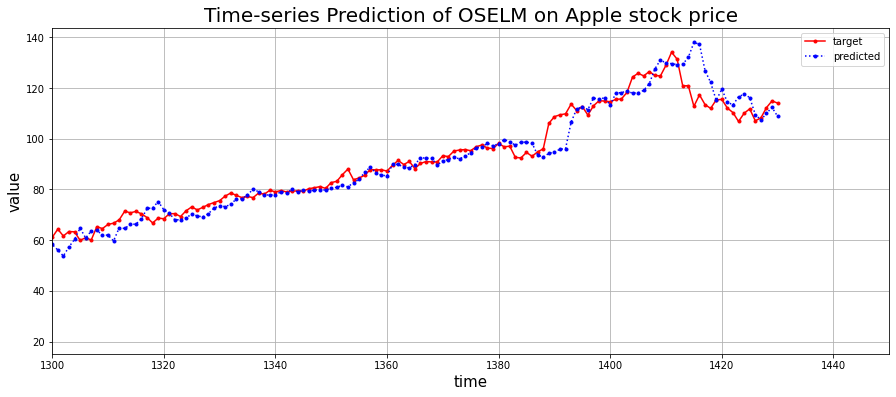

Prediction plot is saved to./predictionPlot.png


In [16]:
algorithm= net.name
plt.figure(figsize = (15, 6))
targetPlot,=plt.plot(target, label = 'target', color = 'red', marker = '.', linestyle = '-')
predictedPlot,=plt.plot(predictions, label = 'predicted', color = 'blue', marker = '.', linestyle = ':')
plt.xlim([1300, 1450])
#plt.ylim([0, 30000])
plt.ylabel('value', fontsize = 15)
plt.xlabel('time', fontsize = 15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of ' + algorithm + ' on Apple stock price', fontsize = 20, fontweight = 40)
plot_path = './predictionPlot.png'
plt.savefig(plot_path, bbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction plot is saved to'+plot_path)

In [17]:
print(predictions.shape)

(1431,)


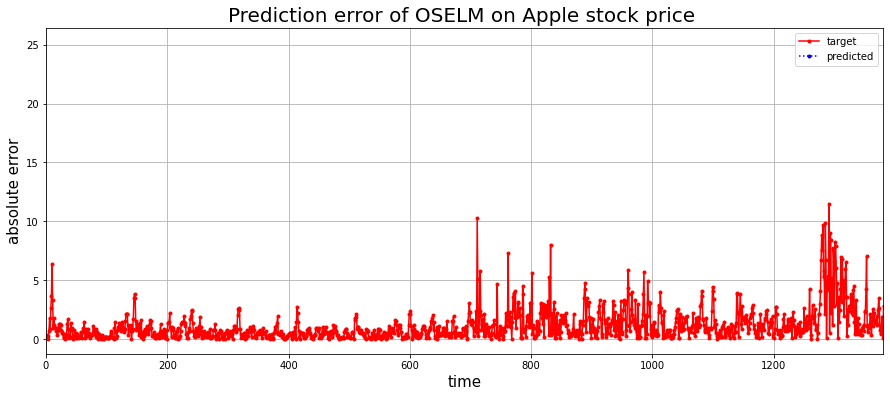

Prediction error plot is saved to./predictionErrorPlot.png


In [18]:
algorithm= net.name
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(np.abs(target-predictions),label='target',color='red',marker='.',linestyle='-')
plt.xlim([0,1380])
#plt.ylim([0, 30000])
plt.ylabel('absolute error',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Prediction error of '+algorithm+' on Apple stock price ',fontsize=20,fontweight=40)
plot_path = './predictionErrorPlot.png'
plt.savefig(plot_path,bbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction error plot is saved to'+plot_path)